# Chapter 27. Power-based connectivity

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from numpy.polynomial.polynomial import polyfit
from scipy.stats import spearmanr, pearsonr, kstest, rankdata
from numpy.fft import fft, ifft

In [4]:
a = np.random.randn(100)
b = np.random.randn(100)

corr1 = np.corrcoef(a, b)

a1 = a-a.mean()
b1 = b-b.mean()

corr2 = a1 @ b1 /(np.linalg.norm(a1) * np.linalg.norm(b1))

print(corr1[0,1], corr2)
assert np.isclose(corr1[0,1], corr2)

0.06971601580020348 0.06971601580020341


### Figure 27.1

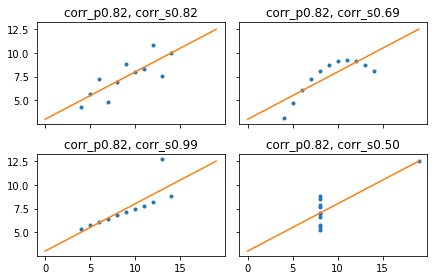

In [5]:
anscombe = [
  # series 1    series 2    series 3     series 4
    [10, 8.04,   10, 9.14,   10, 7.46,    8, 6.58],
     [8, 6.95,    8, 8.14,    8, 6.77,    8, 5.76],
    [13, 7.58,   13, 8.76,   13,12.74,    8, 7.71],
     [9, 8.81,    9, 8.77,    9, 7.11,    8, 8.84],
    [11, 8.33,   11, 9.26,   11, 7.81,    8, 8.47],
    [14, 9.96,   14, 8.10,   14, 8.84,    8, 7.04],
     [6, 7.24,    6, 6.13,    6, 6.08,    8, 5.25],
     [4, 4.26,    4, 3.10,    4, 5.39,    8, 5.56],
    [12,10.84,   12, 9.13,   12, 8.15,    8, 7.91],
     [7, 4.82,    7, 7.26,    7, 6.42,    8, 6.89],
     [5, 5.68,    5, 4.74,    5, 5.73,   19,12.50],
    ]
anscombe = np.asarray(anscombe)

# plot and compute corrs

fig, ax = plt.subplots(2,2, sharex='all', sharey='all')

for i in range(4):
    idx = np.unravel_index(i, (2,2))
    x, y = anscombe[:, i*2], anscombe[:, i*2+1]
    ax[idx].plot(x,y, '.')
    b, m = polyfit(x, y, 1)

    ax[idx].plot(range(20), m*range(20)+b)
    ax[idx].set(title=f"corr_p{pearsonr(x,y)[0]:.2f},"
                      f" corr_s{spearmanr(x,y)[0]:.2f}")
fig.tight_layout()

### Figure 27.2

KstestResult(statistic=0.9900591234387769, pvalue=0.0)
KstestResult(statistic=0.841158512400247, pvalue=0.0)
KstestResult(statistic=0.008677923815338162, pvalue=0.43625610086014377)


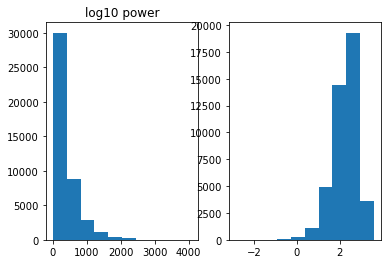

In [6]:
data = scipy.io.loadmat('sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]
EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

sensor = "Fz"
center_freq = 10
wavelet_cycles = 4.5
s_rate = EEGsrate

data = np.reshape(EEGdata[EEGchanlocslabels==sensor], (EEGpnts*EEGtrials), order="f")

def filt(x, center_freq, wavelet_cycles):
    """Helper function"""

    time = np.arange(-1, 1 + 1/s_rate, 1/s_rate)  # time for wavelet from -1 to 1 in secs
    s = wavelet_cycles/(2*np.pi*center_freq)  # stdev of Gaussian
    wavelet = np.exp(2*np.pi*1j*center_freq*time) * np.exp(-time**2 / (2*s**2))

    # fft params
    n_wavelet =  len(wavelet)
    n_data = len(x)
    n_convolution = n_data+n_wavelet-1
    half_of_wavelet_size = len(wavelet)//2

    # fft of wavelet and eeg data
    convolution_result_fft = ifft(fft(wavelet, n_convolution) * fft(x, n_convolution))*np.sqrt(s)
    filtered = convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size]
    filtered = np.abs(np.reshape(filtered, (EEGpnts, EEGtrials), order="f"))**2
    return filtered

convolution_result_fft = filt(data, center_freq, wavelet_cycles)
convolution_result_fft =  convolution_result_fft[100:-100]

# plot distr power data
fig, ax = plt.subplots(1,2)
ax[0].hist(convolution_result_fft.flatten())
ax[0].set(title="power")

ax[1].hist(np.log10(convolution_result_fft.flatten()))
ax[0].set(title="log10 power")


# test for non-normality. P>.05 indicates that we cannot reject null hypothesis that data is drawn
# from normal distribution
print(kstest(convolution_result_fft.flatten(), 'norm'))
print(kstest(np.log10(convolution_result_fft.flatten()), 'norm'))
print(kstest(np.random.randn(10000), 'norm'))

### Figure 27.3

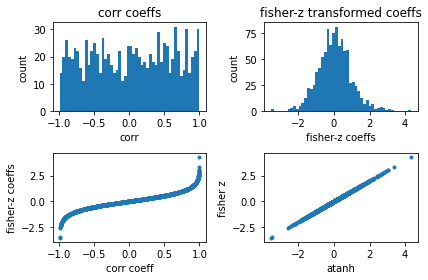

In [7]:
lots_of_corr_coefs = np.random.rand(1000)*2 - 1
fisher_z_coeffs = .5 * np.log( (1+lots_of_corr_coefs)/(1-lots_of_corr_coefs) )

fig, ax = plt.subplots(2,2)

ax[0,0].hist(lots_of_corr_coefs, 50)
ax[0,0].set(title="corr coeffs", xlabel="corr", ylabel="count")

ax[0,1].hist(fisher_z_coeffs, 50)
ax[0,1].set(title="fisher-z transformed coeffs", xlabel="fisher-z coeffs", ylabel="count")

ax[1,0].plot(lots_of_corr_coefs, fisher_z_coeffs, '.')
ax[1,0].set(ylabel="fisher-z coeffs", xlabel="corr coeff")

ax[1,1].plot(np.arctanh(lots_of_corr_coefs), fisher_z_coeffs, '.')
ax[1,1].set(ylabel="fisher z", xlabel="atanh")

fig.tight_layout()

### Figure 27.4

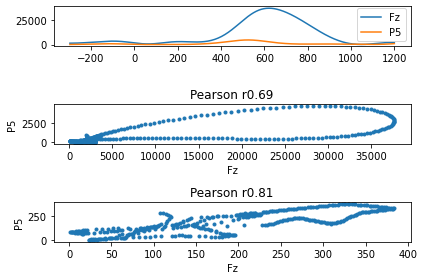

In [11]:
sensor1 = "Fz"
sensor2 = "P5"

center_freq = 6
trial2plot = 9  # off by one from matlab's

data1 = EEGdata[EEGchanlocslabels==sensor1].flatten(order="F")
data2 = EEGdata[EEGchanlocslabels==sensor2].flatten(order="F")

times2plot = np.argwhere(np.logical_and(EEGtimes> -300, EEGtimes<1200)).squeeze()

filtered1 = filt(data1, center_freq, wavelet_cycles)
filtered2 = filt(data2, center_freq, wavelet_cycles)

filtered1 = np.reshape(filtered1, (EEGpnts, EEGtrials), order="f")[:, trial2plot]
filtered2 = np.reshape(filtered2, (EEGpnts, EEGtrials), order="f")[:, trial2plot]

fig, ax = plt.subplots(3,1)
ax[0].plot(EEGtimes[times2plot], filtered1[times2plot], label=sensor1)
ax[0].plot(EEGtimes[times2plot], filtered2[times2plot], label=sensor2)
ax[0].legend()

ax[1].plot(filtered1[times2plot], filtered2[times2plot], '.')
ax[1].set(xlabel=sensor1, ylabel=sensor2,
          title=f"Pearson r{pearsonr(filtered1[times2plot], filtered2[times2plot])[0]:.2f}")

ax[2].plot(rankdata(filtered1[times2plot]), rankdata(filtered2[times2plot]), '.')
ax[2].set(xlabel=sensor1, ylabel=sensor2,
          title=f"Pearson r{spearmanr(filtered1[times2plot], filtered2[times2plot])[0]:.2f}")

fig.tight_layout()


### Figure 27.5

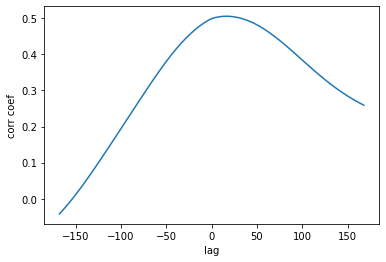

In [61]:
n_lags = np.round(EEGsrate/center_freq).astype(int)


lags, c, _, _ = plt.xcorr(rankdata(filtered1), rankdata(filtered2), detrend= lambda x: x-x.mean(),
                          normed=True, maxlags=n_lags, usevlines=False, linestyle='-', marker='x');
plt.cla()
plt.plot(lags/EEGsrate*1000, c)
plt.xlabel('lag'); plt.ylabel('corr coef');

### Figure 27.6

[Text(0.5, 1.0, 'corr over trials from seed Fz, 6Hz and200-400ms'),
 Text(0.5, 0, 'time (ms)'),
 Text(0, 0.5, 'frequency (Hz)')]

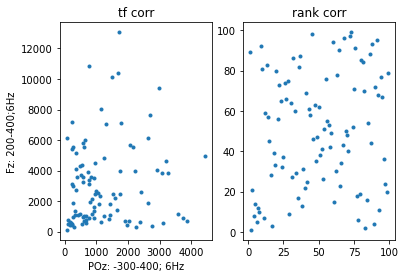

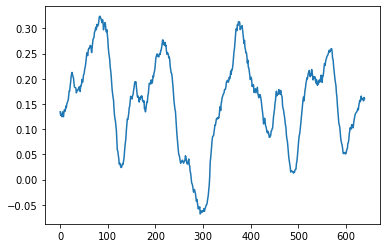

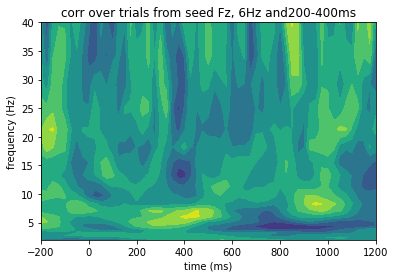

In [166]:
sensor1 = 'POz'
sensor2 = 'Fz'

time_win1 = (-300, -100)
time_win2 = (200, 400)

center_freq1 = 6
center_freq2 = 6

time_idx1 = np.zeros_like(time_win1)
time_idx2 = np.zeros_like(time_win2)


for i in range(2):

    time_idx1[i] = np.argmin(np.abs(EEGtimes-time_win1[i]))
    time_idx2[i] = np.argmin(np.abs(EEGtimes-time_win2[i]))

time = np.arange(-1, 1+1/EEGsrate, 1/EEGsrate)
half_of_wavelet_size = len(time)//2
wavelet_cycles = 4.5

data1 = np.reshape(EEGdata[EEGchanlocslabels==sensor1], (EEGpnts*EEGtrials), order="f")
data2 = np.reshape(EEGdata[EEGchanlocslabels==sensor2], (EEGpnts*EEGtrials), order="f")

analytic_signal1 = filt(data1, center_freq1, wavelet_cycles)
analytic_signal2 = filt(data2, center_freq2, wavelet_cycles)

tf_window_data1 = analytic_signal1[time_idx1[0]:time_idx1[1], :].mean(0)
tf_window_data2 = analytic_signal2[time_idx2[0]:time_idx2[1], :].mean(0)

fig, ax = plt.subplots(1,2)
ax[0].plot(tf_window_data1, tf_window_data2, '.')
ax[0].set(title=f'tf corr',
          xlabel=f'{sensor1}: {time_win1[0]}-{time_win2[1]}; {center_freq1}Hz',
          ylabel=f'{sensor2}: {time_win2[0]}-{time_win2[1]};{center_freq2}Hz')

ax[1].plot(rankdata(tf_window_data1), rankdata(tf_window_data2), '.')
ax[1].set(title='rank corr')

corr_ts = np.zeros_like(EEGtimes)
for i in range(EEGpnts):
    corr_ts[i]  = spearmanr(analytic_signal1[i,:], analytic_signal2[i,:])[0]

fig, ax = plt.subplots(1,1)

ax.plot(corr_ts)

times2save = np.arange(-200, 1225, 25)
frex = np.logspace(np.log10(2), np.log10(40), 20)

times2save_idx = [np.argmin(np.abs(EEGtimes - t)) for t in times2save]

seeddata_rank = rankdata(tf_window_data2)

expl_corrs = np.zeros((len(frex), len(times2save)))

for fi in range(len(frex)):
    analytic_signal1 = filt(data1, frex[fi],wavelet_cycles)
    for ti in range(len(times2save)):
        y = analytic_signal1[times2save_idx[ti],:]
        expl_corrs[fi, ti] = 1 - 6 * sum((seeddata_rank -
                                          rankdata(y))**2) \
                             / (EEGtrials*(EEGtrials**2-1))

fig, ax = plt.subplots(1,1)

ax.contourf(times2save, frex, expl_corrs)
ax.set(title=f'corr over trials from seed {sensor2}, {center_freq2}Hz and'
             f'{time_win2[0]}-{time_win2[1]}ms', xlabel='time (ms)', ylabel='frequency (Hz)')

### Figure 27.7 (and 27.8)

[None]

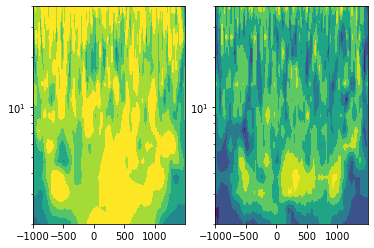

In [173]:
seed_chan     = 'Fz'
target_chan   = 'F6'
control_chan  = 'F1'

min_freq = 2
max_freq = 40
num_frex = 15
frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq),num_frex)

times2save = np.arange(-200, 800+50, 50)
# times2save = EEGtimes  # comment this out for 27.7; uncomment for 27.8

times2save_idx = [np.argmin(np.abs(EEGtimes - t)) for t in times2save]

data_seed = np.reshape(EEGdata[EEGchanlocslabels==seed_chan], (EEGpnts*EEGtrials), order="f")
data_target = np.reshape(EEGdata[EEGchanlocslabels==target_chan], (EEGpnts*EEGtrials), order="f")
data_control = np.reshape(EEGdata[EEGchanlocslabels==control_chan], (EEGpnts*EEGtrials), order="f")

tf_corr_data = np.zeros((len(frequencies), len(times2save), 2))

def bivar_corr(x, y):
    return 1-6*np.sum((x-y)**2)/(EEGtrials*(EEGtrials**2-1))

for fi in range(len(frequencies)):
    conv_result_seed = rankdata(filt(data_seed, frequencies[fi], wavelet_cycles)[times2save_idx, :], axis=1)
    conv_result_target = rankdata(filt(data_target, frequencies[fi], wavelet_cycles)[times2save_idx,:], axis=1)
    conv_result_control = rankdata(filt(data_control, frequencies[fi], wavelet_cycles)[times2save_idx, :], axis=1)

    for ti in range(len(times2save)):
        r_st = bivar_corr(conv_result_seed[ti], conv_result_target[ti])
        r_sc = bivar_corr(conv_result_seed[ti], conv_result_control[ti])
        r_tc = bivar_corr(conv_result_control[ti], conv_result_target[ti])

        tf_corr_data[fi, ti, 0 ] = r_st

        # partial correlation
        tf_corr_data[fi, ti,1] = (r_st-r_sc*r_tc) / (np.sqrt(1-r_sc**2)*np.sqrt(1-r_tc**2))


fig, ax = plt.subplots(1, 2)
ax[0].contourf(times2save, frequencies, tf_corr_data[..., 0], vmin=0, vmax=.6)
ax[0].set(yscale='log')
ax[1].contourf(times2save, frequencies, tf_corr_data[..., 1], vmin=0, vmax=.6)
ax[1].set(yscale='log')

### Figure 27.8

Same as prev fig but with times2save=EEGtimes

[(-200.0, 800.0)]

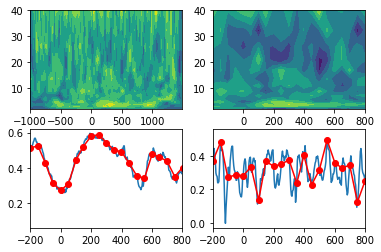

In [185]:
ds_timesidx = [np.argmin(np.abs(EEGtimes -t)) for t in np.arange(-200,850,50)]
lo_freq = np.argmin(np.abs(frequencies-4.7))
hi_freq = np.argmin(np.abs(frequencies-32))

fig, ax = plt.subplots(2,2)
ax[0,0].contourf(times2save,frequencies,tf_corr_data[...,1])

ax[0,1].contourf(times2save[ds_timesidx],frequencies,tf_corr_data[:,ds_timesidx,1])

ax[1,0].plot(EEGtimes, tf_corr_data[lo_freq,:,1])
ax[1,0].plot(EEGtimes[ds_timesidx], tf_corr_data[lo_freq, ds_timesidx,1],'ro-')
ax[1,0].set(xlim=(-200,800), title='effect of downsampling on lo freq')

ax[1,1].plot(EEGtimes, tf_corr_data[hi_freq,:,1])
ax[1,1].plot(EEGtimes[ds_timesidx], tf_corr_data[hi_freq, ds_timesidx,1],'ro-')
ax[1,1].set(xlim=(-200,800), title='effect of downsampling on hi freq')

### Figure 27.9

Omitted because this fig is mainly benchmarking